# Building an AutoEncoder for denoising handwritten images with PyTorch.

In this project we will be creating the Autoencoder model for denoising handwritten images. 

In this project we will be using MNIST dataset, further details can be foun __[here](https://en.wikipedia.org/wiki/MNIST_database)__.


An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....


In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [2]:
data = pd.read_csv('mnist_dataset.csv')
data.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.iloc[3].value_counts().sort_index() # checking the values range from a random image  

3
0      671
3        1
4        1
5        2
6        3
      ... 
245      2
247      1
251      3
254     12
255      1
Name: count, Length: 77, dtype: int64

In digital imaging, colors and intensities are often represented using a range of values, where 0 signifies the absence of color or intensity, and the maximum value represents full color or maximum brightness. In the case of an 8-bit grayscale image, the pixel values range from 0 to 255, with 0 representing black and 255 representing white.

Dividing each pixel value by 255 in the code normalizes the pixel values to a range between 0 and 1, which is a common practice in various image processing and machine learning applications. This normalization process allows for more efficient computation and standardizes the data to a common scale, making it easier to compare different images or process them using various algorithms.

In [4]:
image = data.iloc[3]
image = np.array(image).astype('float32')
image = np.reshape(image, (28,28))
image = image / 255

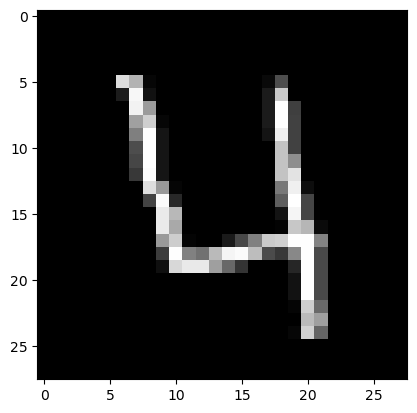

In [5]:
plt.imshow(image, cmap = 'gray') 
# The cmap='gray' argument specifies the colormap used to grayscale, 
# which is suitable for displaying images with a single channel of intensity values.

In [6]:
image = data.iloc[18]
image = np.array(image).astype('float32')
image = np.reshape(image, (28,28))
image = image / 255

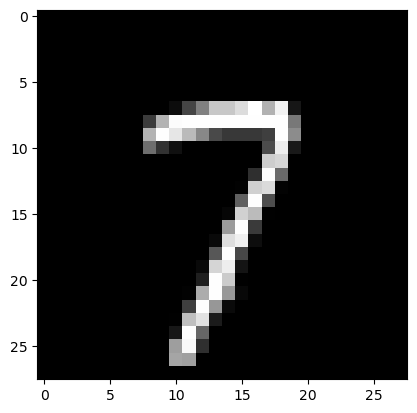

In [7]:
plt.imshow(image, cmap = 'gray')

Now we will generate a random noise matrix with the same shape as the original image using np.random.randn. This random noise is added to each pixel in the original image, effectively creating a noisy version of the image. The factor 0.2 controls the magnitude of the noise added.

In [8]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

np.clip () function ensures that the pixel values of the noisy image are within the range of 0 and 1. 

This means that any pixel value less than 0 will be set to 0 and any value greater than 1 will be set to 1.

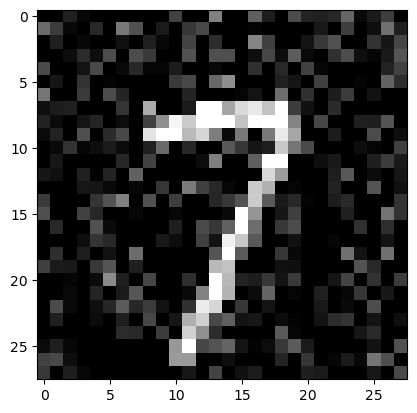

In [9]:
plt.imshow(noisy_image, cmap = 'gray')

# Data Preparation 

<img src='dataset.png' alt='drawing' width='400'/>

In [10]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [11]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self, csv_file, noise_factor = 0.2, transform = None):
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28, 28, 1)) / 255
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        
        sample = (noisy_img, img)
        
        # Pytorch uses (channel, height, width) convention, thus we're going to apply ToTensorForAE() transform 
        # in order for the image area to be converted into torch tensor and also the axis convention to be 
        # changed from (height, width, channel) to (channel, height, width). The if statement below helps in 
        # applying the transformation.
        
        if self.transform:
            sample =self.transform(sample)
            
        return sample

### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [12]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv', transform = ToTensorForAE())

In [13]:
print('Size of trainset: {}'.format(len(trainset)))

Size of trainset: 42000


In [14]:
noisy_img, org_img = trainset[32]

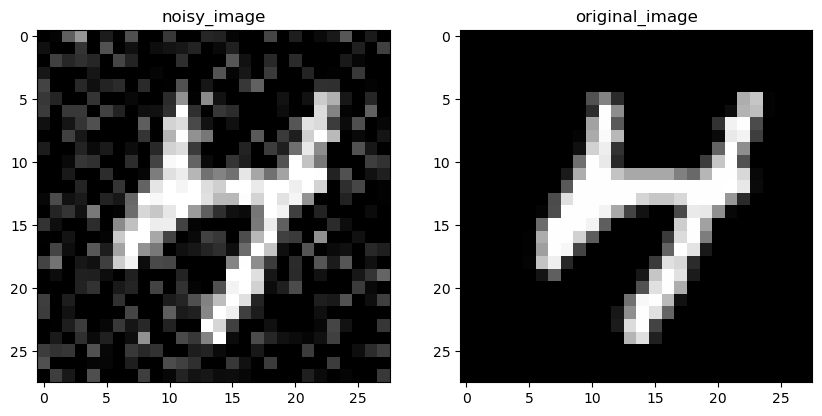

In [15]:
show_image(noisy_img, org_img)

# Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

In [17]:
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)
# shuffling the data is preferred to avoid any possible bias in the model due to the order of the data

The random shuffling of data is beneficial for reducing any bias that might be introduced due to the ordering of the data. However, it's important to note that each epoch should cover the entire dataset, including all data points, for effective training. While it is possible to set shuffle to False to avoid issues with missing data, this may introduce its own biases, particularly if the data is organized in any particular order.

In [18]:
dataiter = iter(trainloader) # extracting data from the trainloader one batch at a time
noisy_img, org_img = next(dataiter) # retrieving next batch from the iterator 

print('Shape of one loading batch: {}'.format(noisy_img.shape))
print('Total no. of batches: {}'.format(len(trainloader)))
print('Total no. of examples: {}'.format(len(trainloader.dataset)))

Shape of one loading batch: torch.Size([16, 1, 28, 28])
Total no. of batches: 2625
Total no. of examples: 42000


# Create AutoEncoder Model

In this task, we'll begin by establishing two networks: the encoder network and the decoder network. The encoder network will generate a compressed representation of the input image, which, in our case, is the noisy image. The decoder network will then utilize this compressed representation to reconstruct the image.
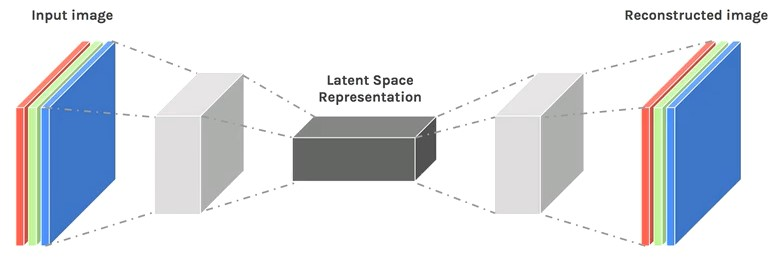

In various models, particularly in generative models like autoencoders and variational autoencoders, the latent space is used to represent the encoding of data into a lower-dimensional space, often enabling the generation of new data with similar characteristics.

In [19]:
from torch import nn
from torchsummary import summary

In [23]:
def Encoder():
    
    enc = nn.Sequential(
    
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2)),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2))
    )
    return enc

In [32]:
def Decoder():
    
    dec = nn.Sequential(
        
    nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2, 2), stride = 2),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (2, 2), stride = 2),
    nn.Sigmoid(),
    )
    
    return dec

Connecting these both layers and building the model

In [33]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, inp_imgs):
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)
        
        return decoder_out
    
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [34]:
summary(model, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [36]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10

for i in range(epochs):
    
    train_loss = 0.0
    
    model.train()
    for batch in tqdm(trainloader):
        
        noisy_img, org_img = batch
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, org_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(trainloader)
    
    print('Epoch: {} Train Loss: {}'.format(i+1, avg_train_loss))

After running the training loop we can see that the loss is decreasing within each epoch, as it was expected. 

# Plot Results.

In the code snippet below, the model is put into evaluation mode using model.eval() which typically disables features like dropout and batch normalization.

torch.Size([1, 28, 28])


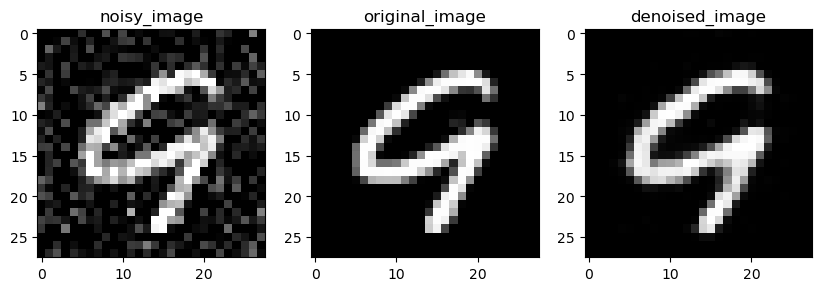

In [40]:
model.eval()

with torch.no_grad(): # ensuring that no gradient information is stored during the evaluation
    
    dataiter = iter(trainloader)
    sample = next(dataiter)  # holds a batch of images with corresponding noisy and original images
    
    noisy_img, org_img = sample # the noisy image and the original image are extracted from the sample.
    
    index = 2 # index of an image within the batch, between 0-15
    
    denoised_img = model(noisy_img[index].unsqueeze(0)) # reshaping denoised image with unsqueeze to comply with the model's expected input shape
    print(denoised_img.squeeze(0).shape)
    
    show_image(noisy_img[index], org_img[index], denoised_img.squeeze(0))
    # denoised_img.squeeze(0) ensures the image has the appropriate dimensions for display.

Denoised image is the model’s output, which is almost identical to the original image. 

Apart from denoising we can also use Autoencoder for various other tasks such as colorization of images, where input image is greyscale and output is colorized image. 

Please note, that for the sake of keeping this exercise relatively simple we did not split the dataset into training, validation and test parts. 
